In [43]:
%matplotlib inline
import pandas as pd
import numpy as np
from source.model import solve_hjb_y, solve_hjb_y_jump
from source.utilities import find_nearest_value
from source.simulation import simulate_jump
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['legend.frameon'] = False

# 1 Parameters
We use the following values for the parameters listed below throughout:

| Parameters | values |
| :---:| :---|
|$\delta$ |  0.01 |
|$\eta$ | 0.032 | 
|$\bar y$ | 2 |
|$\gamma_1$ | 0.00017675 |
|$\gamma_2$ | 0.0044|
|$\gamma_3^1$| 0.0000|
|$\gamma_3^2$| 0.0394|
|$\gamma_3^3$| 0.7706|
|$\varsigma'$| [0.0022, 0]|





# 2. Computation

Choose a set of uncertainty parameters $(\xi_b, \xi_p, \xi_a)$ and proceed with the following two step computation. We explore 144 climate models and 3 damage functions, *i.e.* $L=144$ and $M=3$.

## 2.1 Step I:
Solve the following HJB for $\gamma_3^m \in \{\gamma_3^1, \gamma_3^2, \gamma_3^3\}$ on $y \in [0,4]$ to get the corresponding $\phi_m(y)$ with $m = 1,2,3$:

$$
\begin{aligned}
0 = \max_{\tilde e} \min_{\omega^a_\ell : \sum_{\ell=1}^L \omega^a_\ell = 1}  &- \delta \phi_m(y) +  \eta \log\tilde e \\
& + \frac{1}{2} \left(\frac{d^2 \phi_m}{dy^2} + \frac{ (\eta - 1)}{\delta} \left(\gamma_2 + \gamma_3\mathbb{I}\{y>\bar y\} \right) \right)(\tilde e)^2 |\varsigma|^2  \\
& - \frac{1}{2\xi_b} \left[ \frac{d\phi_m}{dy}    + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y + \gamma_3 (y-\bar y)\mathbb{I}\{y > \bar y\})\right]^2 \cdot |\varsigma|^2 (\tilde e)^2 \\
\\
& + \sum_{\ell=1}^{L} \omega_\ell^a \left(\frac{d\phi_m}{dy}+ \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y + \gamma_3^m (y - \bar y)\mathbb{I}\{y > \bar y\} ) \right)\theta_\ell \tilde e   \\
\\
& + \xi_a \sum_i \omega^a_\ell(\log \omega^a_\ell - \log \pi^a_\ell)
\end{aligned}
$$

## 2.2 Step II:
Given the above $\phi_1$, $\phi_2$ and $\phi_3$, solve the following HJB for $\phi(y)$ on $y \in [0, \bar y]$:

$$
\begin{aligned}
0 = \max_{\tilde e} \min_{\omega^a_\ell : \sum_{\ell=1}^L \omega^a_\ell = 1}  &- \delta \phi(y) +  \eta \log\tilde e \\
&+ \frac{1}{2} \left(\frac{d^2 \phi_m}{dy^2} + \frac{ (\eta - 1)}{\delta} \left(\gamma_2 + \gamma_3\mathbb{I}\{y>\bar y\} \right) \right)(\tilde e)^2 |\varsigma|^2 \\
\\
& - \frac{1}{2\xi_b} \left[ \frac{d\phi}{dy}    + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y + \gamma_3 (y-\bar y)\mathbb{I}\{y > \bar y\})\right]^2 \cdot |\varsigma|^2 (\tilde e)^2 \\
\\
&  + \sum_{\ell=1}^{L} \omega_\ell^a \left(\frac{d\phi}{dy}+ \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y + \gamma_3^m (y - \bar y)\mathbb{I}\{y > \bar y\} ) \right)\theta_\ell \tilde e   \\
\\
 & + \xi_a \sum_{\ell=1}^L \omega^a_\ell(\log \omega^a_\ell - \log \pi^a_\ell)
\end{aligned}
$$

$$
s.t \quad \phi(\bar y) \approx - \xi_p \log \left( \sum_{m=1}^M {\pi^d_m} \exp ( - \frac{1}{\xi_p}\phi_m(\bar y) )\right)
$$

In [11]:
# Uncertainty parameters
ξ_w = 10_000
ξ_a = 1/100
ξ_p = 5

# Preference
η = .032
δ = .01

# Climate sensitivity
θ_list = pd.read_csv('data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)

# Damage function
σ_y = 1.2*np.mean(θ)
y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = np.array([0, .0197*2, .3853*2])
πd_o = np.array([1./3, 1./3, 1./3])

y_step = .02
y_grid_long = np.arange(0., 4., y_step)
y_grid_short = np.arange(0., 2+y_step, y_step)
n_bar = find_nearest_value(y_grid_long, y_bar) + 1

# Prepare ϕ conditional on low, high, extreme damage
model_res_list = []
for γ_2p_i in γ_2p:
    model_args = (η, δ, σ_y, y_bar, γ_1, γ_2, γ_2p_i, θ, πc_o, ξ_w, ξ_a) 
    model_res = solve_hjb_y(y_grid_long, model_args, v0=None, ϵ=1.,
                            tol=1e-8, max_iter=5_000, print_iteration=False)
    model_res_list.append(model_res)

ϕ_list = [res['v'] for res in model_res_list]
certainty_equivalent = -ξ_p*np.log(np.average(np.exp(-1./ξ_p*np.array(ϕ_list)), axis=0, weights=πd_o))
# Change grid from 0-4 to 0-2
ϕ_i = np.array([temp[:n_bar] for temp in ϕ_list])

# Compute ϕ with jump (impose boundary condition)
model_args = (η, δ, σ_y, y_bar, γ_1, γ_2, γ_2p, θ, πc_o, ϕ_i, πd_o, ξ_w, ξ_p, ξ_a)
model_res = solve_hjb_y_jump(y_grid_short, model_args, 
                             v0=np.average(ϕ_i, weights=πd_o, axis=0),
                             ϵ=1., tol=1e-8, max_iter=5_000, print_iteration=False)

Converged. Total iteration 5000: LHS Error: 2.544698815576396e-05; RHS Error 6.901213676188678e-05
Converged. Total iteration 1507: LHS Error: 9.965662961519683e-09; RHS Error 0.00047002516558698054
Converged. Total iteration 1621: LHS Error: 9.952296764481616e-09; RHS Error 0.002278795638726125
Converged. Total iteration 443: LHS Error: 9.762318953221438e-09; RHS Error 0.0008703085083172288


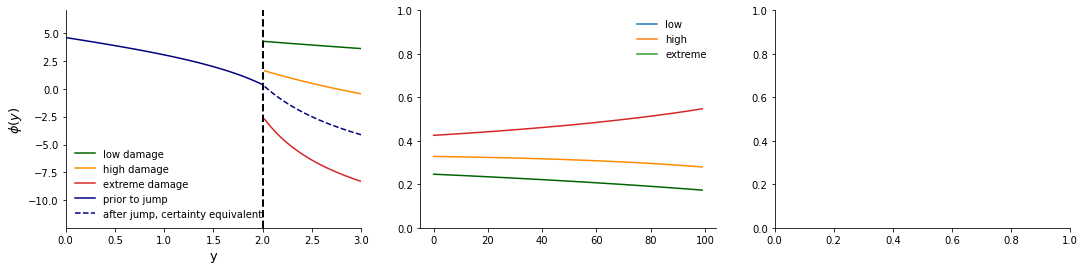

In [76]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
# plot 1: value matching
ax1.plot(y_grid_long[n_bar:], ϕ_list[0][n_bar:], label="low damage", color="darkgreen")
ax1.plot(y_grid_long[n_bar:], ϕ_list[1][n_bar:], label="high damage", color="darkorange")
ax1.plot(y_grid_long[n_bar:], ϕ_list[2][n_bar:], label="extreme damage", color="tab:red")
ax1.plot(model_res['y'], model_res['v'], color="navy", label="prior to jump")
ax1.plot(y_grid_long[n_bar:], certainty_equivalent[n_bar:], 
         color="navy", linestyle="dashed", label="after jump, certainty equivalent")
y_min = np.min(ϕ_list[2])*1.2
y_max = np.max(ϕ_list[0])*1.2
ax1.vlines(2., ymin=y_min, ymax=y_max, color='black', linestyle='dashed', linewidth=2.)
ax1.set_xlim(0, 3.)
ax1.set_ylim(y_min, y_max)
ax1.legend()
ax1.set_xlabel('y', fontsize=13)
ax1.set_ylabel(r'$\phi(y)$', fontsize=13)
# plot 2: trajectories of distorted probability of damage functions
colors = ["darkgreen", "darkorange", "tab:red"]
lines = ax2.plot(simulation_res["πdt"])
ax2.legend(["low", "high", "extreme"])
ax2.set_ylim(0,1)
for i in range(len(lines)):
    lines[i].set_color(colors[i])
plt.show()

In [45]:
θ_list = pd.read_csv('data/model144.csv', header=None).to_numpy()[:, 0]/1000.
simulation_res = simulate_jump(model_res, θ_list)

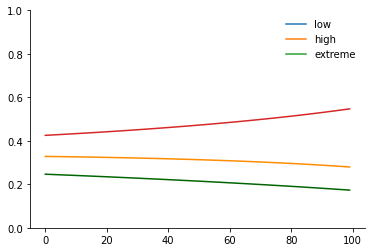

In [67]:
colors = ["darkgreen", "darkorange", "tab:red"]
lines = plt.plot(simulation_res["πdt"])
plt.legend(["low", "high", "extreme"])
plt.ylim(0,1)
for i in range(len(lines)):
    lines[i].set_color(colors[i])

(0.0, 0.2)

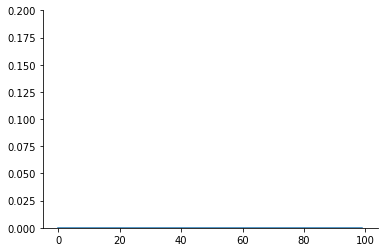

In [64]:
plt.plot(simulation_res["ht"])
plt.ylim(0,0.2)

In [ ]:
def plot_results(y_grid_long, n_bar, ϕ_list, ξ_list, model_list)

In [13]:
from ipywidgets import widgets, interact

In [35]:
def browse_images(param_list):
    n = len(param_list)
    def view_image(i):
        plt.plot(y_grid_long[n_bar:], ϕ_list[0][n_bar:], label="low damage", color="darkgreen")
        plt.plot(y_grid_long[n_bar:], ϕ_list[1][n_bar:], label="high damage", color="darkorange")
        plt.plot(y_grid_long[n_bar:], ϕ_list[2][n_bar:], label="extreme damage", color="tab:red")
        plt.plot(y_grid_short, model_res['v'], color="navy", label="prior to jump")
        plt.plot(y_grid_long[n_bar:], certainty_equivalent[n_bar:], 
                 color="navy", linestyle="dashed", label="after jump, certainty equivalent")
        y_min = np.min(ϕ_list[2])*1.2
        y_max = np.max(ϕ_list[0])*1.2
        plt.vlines(2., ymin=y_min, ymax=y_max, color='black', linestyle='dashed', linewidth=2.)
        plt.xlim(0, 3.)
        plt.ylim(y_min, y_max)
        plt.legend()
        plt.xlabel('y', fontsize=13)
        plt.ylabel(r'$\phi(y)$', fontsize=13)
        plt.show()
    interact(view_image, i=(0,n-1))

In [36]:
param_list = [1,2,3]
browse_images(param_list)

interactive(children=(IntSlider(value=1, description='i', max=2), Output()), _dom_classes=('widget-interact',)…

In [41]:
model_res.keys()

dict_keys(['v', 'dvdy', 'dvddy', 'e_tilde', 'h', 'πc', 'g', 'πd', 'bc', 'y', 'model_args'])

In [42]:
?solve_hjb_y_jump